# Fisher formalism to forecast kSZ SNR.

### Parameters constrained: 6 \$\Lambda{\rm CDM}$ + $A_{\rm kSZ}$ + $\alpha_{\rm radio}$ + $\sigma(\alpha_{\rm radio})$

#### Noise + foreground residuals: tSZ-free x CIB-free cross-ILC from, for example, publish/data/ilc_weights_residuals_agora_fg_model.npy

In [75]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import numpy as np, sys, os, scipy as sc, warnings
sys.path.append('modules/')
import tools, ilc, fisher_tools
import matplotlib.cbook
import scipy.ndimage as ndimage
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

#%pylab notebook
%matplotlib inline
from pylab import *

import copy

In [77]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'


# Get the ILC residuals first

In [78]:
#get the ILC residuals first
which_fg_model = 'agora'

fname = 'publish/data/ilc_weights_residuals_%s_fg_model.npy' %(which_fg_model)
ilc_dict = np.load(fname, allow_pickle = True).item()
print(ilc_dict.keys())

#get experiment Nl_dict
nl_TP_dict = ilc_dict['nl_TP_dict']

#different types of ILC considered
ilc_keyname_arr = ilc_dict['ilc_keyname_arr']
print(ilc_keyname_arr)

#ILC weights
weights_dict = ilc_dict['weights']
print(weights_dict.keys())

#total ILC residuals
total_ilc_residuals_dict = ilc_dict['total_ilc_residuals']
print(total_ilc_residuals_dict.keys())

if (1): #with CCAT-prime
    fname_withccatp = 'publish/data/ilc_weights_residuals_%s_fg_model_withccatp.npy' %(which_fg_model)
    ilc_dict_withccatp = np.load(fname_withccatp, allow_pickle = True).item()

    weights_dict_withccatp = ilc_dict_withccatp['weights']
    
    #get experiment Nl_dict
    nl_TP_dict_withccatp = ilc_dict_withccatp['nl_TP_dict']

    #total ILC residuals
    total_ilc_residuals_dict_withccatp = ilc_dict_withccatp['total_ilc_residuals']
    #print(total_ilc_residuals_dict.keys())
    
    ##print(ilc_dict_withccatp.keys())

#el range
els = ilc_dict['el']

dict_keys(['weights', 'total_ilc_residuals', 'cib_plus_tsz_residuals', 'cib_residuals', 'tsz_residuals', 'noise_residuals', 'radio_residuals', 'nl_TP_dict', 'cl_signal_plus_noise', 'ilc_keyname_arr', 'el'])
['mv' 'tszfree' 'cibfree' 'mvxcibfree' 'mvxtszfree' 'tszfreexcibfree']
dict_keys(['s4_wide', 's4_deep', 'spt3g', 'spt4', 'so_baseline', 'so_goal'])
dict_keys(['s4_wide', 's4_deep', 'spt3g', 'spt4', 'so_baseline', 'so_goal'])


# Experiment names and $f_{\rm sky}$ values

In [79]:
#experiment names and fsky values
exp_specs_dict = {
                  's4_wide': ['S4-Wide', 0.57], 
                  's4_wide_withccatp': ['S4-Wide + FYST', 0.57], 
                  's4_deep': ['S4-Ultra Deep', 0.03], 
                  'spt3g': ['SPT-3G', 0.03],
                  'spt4': ['SPT-3G+SPT-4', 0.03],
                  'so_baseline': ['SO-Baseline', 0.4],
                  'so_baseline_withccatp': ['SO-Baseline + FYST', 0.4], 
                  'so_goal': ['SO-Goal', 0.4],
                  'so_goal_withccatp': ['SO-Goal + FYST', 0.4], 
                  }

#ILC keynames
ilc_keyname_dict = {'mv':'MV', 'tszfree': 'tSZ-free', 'cibfree': 'CIB-free'}

# Setting variables for Fisher forecasting
### Default cosmology: $\texttt{planck_cosmo_version}$ = ${\it Planck}$ 2018.
  * ### Param file used for CAMB: publish/data/params_planck_r_0.0_2018_cosmo.txt
  * ### TT, TE, EE + lowE + lensing in Table 2 of [1807.06209](https://arxiv.org/abs/1807.06209)
  * ### ${\it Planck}$ 2015 is also available.

In [80]:
#some variables for Fisher forecasting
#expname = 's4_wide'
#fsky = exp_specs_dict[expname][1]
planck_cosmo_version = 2015
camb_folder = 'publish/data/CAMB/planck_%s/' %(planck_cosmo_version)
which_spectra = 'lensed'
reqd_ilc_keyname_1 = 'tszfree'
reqd_ilc_keyname_2 = 'cibfree'
max_flux_mJy = 3e-3 #masking threshold used.
if reqd_ilc_keyname_1 != reqd_ilc_keyname_2:
    reqd_ilc_keyname_12 = '%sx%s' %(reqd_ilc_keyname_1, reqd_ilc_keyname_2)
else:
    reqd_ilc_keyname_12 = reqd_ilc_keyname_1

#ksz-related stuffs.
dl_ksz_amp_total = 3. #D_{\ell}^{\rm kSZ} = 3 uK^2 
Aksz = 1. #Amplitude of kSZ.
Aksz_step = Aksz / 100. #stpe for derivative calculation

#radio-related stuffs
spec_index_radio = -0.76 #Radio spectral index fiducial value
spec_index_radio_step = spec_index_radio/100. #stpe for derivative calculation
spec_index_radio_prior = 0.1 #Radio spectral index prior
alpha_radio = spec_index_radio

spec_index_radio_scatter = 0.2 #Radio spectral index fiducial scatter
spec_index_radio_scatter_step = spec_index_radio_scatter/100.
spec_index_radio_scatter_prior = 0.3 #Radio spectral index scatter prior
alpha_radio_sigma = spec_index_radio_scatter

## Pick CMB $C_{\ell}^{\rm xx}$ and derivatives $\dfrac{\partial C_{\ell}^{\rm XX}}{\partial \theta}$ where ${\rm XX} \in [TT, EE, TE]$ and $\theta \in [A_{s},\ h,\ n_{s},\ \Omega_{c}h^{2},\ \Omega_{b}h^{2},\ \tau_{\rm re}]$
### Note:
* $C_{\ell}$ and the derivatives are already stored and also contain additional parameters namely $\sum m_{\nu}$ and $w_{0}$. Both these parameters are fixed during Fisher forecasting.
* Paramters that are added later (below):
  * $A_{\rm kSZ}$ - Amplitude of the kSZ power spectrum $D_{\ell} = 3 \mu {\rm K}^{2}$.
  * $\alpha_{\rm rad}$ - Spectral index of radio point sources.
  * $\sigma(\alpha_{\rm rad})$ - Scatter in the distribution of spectral indices of the radio point sources.

In [81]:
#CMB stuffs
#get fiducual LCDM power spectra computed using CAMB
print('get fiducual LCDM power spectra computed using CAMB')
camb_fname = '%s/cmb_spectra_%s.txt' %(camb_folder, which_spectra)
cl_camb = np.loadtxt(camb_fname)
el_camb = cl_camb[:,0] 
cl_camb_tt = cl_camb[:,1]
dl_fac_camb = el_camb * (el_camb+1)/2/np.pi
cl_dic = {}
cl_dic['TT'] = cl_camb[:,1]
cl_dic['EE'] = cl_camb[:,2]
cl_dic['TE'] = cl_camb[:,3]

#get derivatives of CMB power spectrum for different LCDM parameters.
#They are already computed and stored.
print('get/read derivatives')
camb_deriv_fname = '%s/cmb_spectra_derivs_%s.npy' %(camb_folder, which_spectra)
cl_deriv_dic_tmp = np.load(camb_deriv_fname, allow_pickle = 1).item()
cl_deriv_dic = {}
param_names = []
for p in sorted( cl_deriv_dic_tmp ):
    if p == 'ell': continue    
    cl_deriv_dic[p]={}
    if planck_cosmo_version == 2018:
        cl_deriv_dic[p]['TT'] = cl_deriv_dic_tmp[p]['TT']
        cl_deriv_dic[p]['EE'] = cl_deriv_dic_tmp[p]['EE']
        cl_deriv_dic[p]['TE'] = cl_deriv_dic_tmp[p]['TE']
    else:
        cl_deriv_dic[p]['TT'] = cl_deriv_dic_tmp[p][0]
        cl_deriv_dic[p]['EE'] = cl_deriv_dic_tmp[p][1]
        cl_deriv_dic[p]['TE'] = cl_deriv_dic_tmp[p][2]
    
    if p == 'As' and planck_cosmo_version == 2015:
        cl_deriv_dic[p]['TT'] *= 1e9
        cl_deriv_dic[p]['EE'] *= 1e9
        cl_deriv_dic[p]['TE'] *= 1e9
        
    param_names.append( p )
    
#interpolate CAMB spectra / derivatives on the desired els.
for which_spec in cl_dic:
    cl_dic[which_spec] = np.interp(els, el_camb, cl_dic[which_spec])
for p in sorted( param_names ):
    for which_spec in cl_deriv_dic[p]:
        cl_deriv_dic[p][which_spec] = np.interp(els, el_camb, cl_deriv_dic[p][which_spec])
        
cl_dic_cmb = copy.deepcopy(cl_dic)

get fiducual LCDM power spectra computed using CAMB
get/read derivatives


## Sanity check - Compare derivatives $\dfrac{\partial C_{\ell}^{\rm XX}}{\partial \theta}$ from ${\it Planck}$ 2015 vs 2018 cosmology.

In [82]:
if (0): #compare 2015 and 2018 derivatives
    planck_cosmo_version_arr = [2015, 2018]
    parent_cl_deriv_dic = {}
    for planck_cosmo_version in planck_cosmo_version_arr:
        camb_deriv_fname = 'publish/data/CAMB/planck_%s/cmb_spectra_derivs_%s.npy' %(planck_cosmo_version, which_spectra)
        cl_deriv_dic_tmp = np.load(camb_deriv_fname, allow_pickle = 1).item()
        cl_deriv_dic = {}
        param_names = []
        for p in sorted( cl_deriv_dic_tmp ):
            if p == 'ell': continue
            cl_deriv_dic[p]={}
            if planck_cosmo_version == 2018:
                cl_deriv_dic[p]['TT'] = cl_deriv_dic_tmp[p]['TT']
                cl_deriv_dic[p]['EE'] = cl_deriv_dic_tmp[p]['EE']
                cl_deriv_dic[p]['TE'] = cl_deriv_dic_tmp[p]['TE']
            else:
                cl_deriv_dic[p]['TT'] = cl_deriv_dic_tmp[p][0]
                cl_deriv_dic[p]['EE'] = cl_deriv_dic_tmp[p][1]
                cl_deriv_dic[p]['TE'] = cl_deriv_dic_tmp[p][2]

            if p == 'As' and planck_cosmo_version == 2015:
                cl_deriv_dic[p]['TT'] *= 1e9
                cl_deriv_dic[p]['EE'] *= 1e9
                cl_deriv_dic[p]['TE'] *= 1e9

            param_names.append( p )
        parent_cl_deriv_dic[planck_cosmo_version] = cl_deriv_dic
        print(param_names)
        
    for p in ['As', 'mnu', 'neff', 'ns', 'ombh2', 'omch2', 'tau', 'thetastar']:
    #for p in ['thetastar']:
        clf()
        ax = subplot(111, yscale = 'log')
        which_spec_dict = {'TT': 'navy', 'EE': 'darkgreen', 'TE': 'darkred'}
        for which_spec in which_spec_dict:
            der2015 = parent_cl_deriv_dic[2015][p][which_spec]
            der2018 = parent_cl_deriv_dic[2018][p][which_spec]
            plot(abs(der2018), color = which_spec_dict[which_spec], ls = '-')
            plot(abs(der2015), color = which_spec_dict[which_spec], ls = '--', lw = 4.)
        show(); sys.exit()
            
        
    

## Get the kSZ temperature power spectrum $C_{\ell}^{\rm kSZ}$ and the derivative $\dfrac{\partial C_{\ell}^{\rm kSZ}}{\partial A_{\rm kSZ}}$.
### Note:
  * ### We assume that the derivatives of $C_{\ell}^{\rm kSZ}$ w.r.t $\Lambda CDM$ parameters is zero. 
      * ### This is not fully correct.
  * ### We also assume that the derivatives of CMB power spectrum $C_{\ell}^{\rm TT}$ w.r.t $A_{\rm kSZ}$ is zero.
  * ### We set EE and TE part of $C_{\ell}^{\rm kSZ} = 0$.


In [83]:
#kSZ stuffs
print('get kSZ spectrum and derivatives')
"""
Assumptions:
1. We assume that the derivatives of cl_kSZ w.r.t LCDM parameters is zero.
    (A) This is not 100 per cent true.
2. We also assume that the derivatives of CMB power spectrum w.r.t AkSZ is zero.
    (A) This is a reasonable assumption.
"""

#get kSZ spectrum now: Flat D_{\ell}^{\rm kSZ} = 3 uK^2 
cl_ksz = fisher_tools.get_cl_ksz(els, Aksz = Aksz, dl_ksz_amp_total = dl_ksz_amp_total)

#add kSZ to cl_dic['TT']
cl_dic['TT'] += cl_ksz

#get deriviatives for Aksz
cl_ksz_low = fisher_tools.get_cl_ksz(els, Aksz = Aksz - Aksz_step, dl_ksz_amp_total = dl_ksz_amp_total)
cl_ksz_high = fisher_tools.get_cl_ksz(els, Aksz = Aksz + Aksz_step, dl_ksz_amp_total = dl_ksz_amp_total)
cl_deriv_dic['Aksz'] = {}
cl_deriv_dic['Aksz']['TT'] = (cl_ksz_high-cl_ksz_low)/( 2 * Aksz_step)
cl_deriv_dic['Aksz']['EE'] = cl_deriv_dic['Aksz']['TT'] * 0.
cl_deriv_dic['Aksz']['TE'] = cl_deriv_dic['Aksz']['TT'] * 0.

#store this in a different dict for future use.
#We will add experiment dependent radio residuals below which will change this dictionary.
cl_dic_ori = copy.deepcopy(cl_dic)
cl_deriv_dic_ori = copy.deepcopy(cl_deriv_dic)

get kSZ spectrum and derivatives


# Define some functions.
#### $\texttt{get_temperature_ilc_residuals}$ - Get the temperature ILC residuals from the ILC dictionary read/stored earlier.
#### $\texttt{get_polarisation_mvilc_residuals}$ - Compute the MV-ILC residuals in polarisation for the desried experiment.
#### $\texttt{get_exp_bands}$ - Get frqeuency bands for the desired experiment.
#### $\texttt{wrapper_get_delta_cl}$ - Wrapper to obtain $\Delta C_{\ell}$.
#### $\texttt{get_radio_residuals}$ - Get ILC radio residuals $C_{\ell}^{\rm rad}$ for the desired experiment.
#### $\texttt{get_radio_spectrum_and_derivatives}$ - Get derivatives of radio power spectrum residuals $\dfrac{\partial C_{\ell}^{\rm rad}}{\partial \theta}$ where $\theta \in [\alpha_{\rm rad}, \sigma(\alpha_{\rm rad})]$.


In [84]:
def get_temperature_ilc_residuals(expname): #Temperature ILC residuals for Nl
    print('\tget ILC residuals for Nl')
    if expname.find('withccatp')>-1:
        dict_to_use = total_ilc_residuals_dict_withccatp
        expname_to_use = expname.replace('_withccatp', '')
    else:
        dict_to_use = total_ilc_residuals_dict
        expname_to_use = expname
    els, total_ilc_residual_mv = dict_to_use[expname_to_use]['mv']
    els, total_ilc_residual_1 = dict_to_use[expname_to_use][reqd_ilc_keyname_1]
    els, total_ilc_residual_2 = dict_to_use[expname_to_use][reqd_ilc_keyname_2]
    els, total_ilc_residual_12 = dict_to_use[expname_to_use][reqd_ilc_keyname_12]
    
    return els, total_ilc_residual_mv, total_ilc_residual_1, total_ilc_residual_2, total_ilc_residual_12
    
def get_polarisation_mvilc_residuals(expname):
    #get MV-ILC for polarisation
    """
    Note that foregrounds are assumed to be unpolarised here.
    So this should simply be a MV noise estimate after taking beams into account.
    """
    dict_for_ilc = {}
    if expname.find('withccatp')>-1:
        expname_to_use = expname.replace('_withccatp', '')
        dict_for_ilc['EE'] = nl_TP_dict_withccatp[expname_to_use]['P']
    else:
        dict_for_ilc['EE'] = nl_TP_dict[expname]['P']
    bands = get_exp_bands(expname)
    mvilc_pol_residuals, mvilc_pol_weights = ilc.get_mvilc_residual_and_weights(bands, els, dict_for_ilc)
    mvilc_pol_residuals = mvilc_pol_residuals[0]

    if (0):#expname == 's4_wide': #show plot for MV-ILC for pol and compare that will noise.
        clf()
        fsval = 14
        band_color_dict = {95: 'navy', 150: 'darkgreen', 220: 'goldenrod', 285: 'orangered', 345: 'darkred', 
                            '410': 'hotpink', 850: 'black'}
        ax=subplot(111, yscale = 'log')
        noise_arr = []
        for (nu1, nu2) in dict_for_ilc['EE']:
            if nu1 != nu2: continue
            curr_nl = dict_for_ilc['EE'][(nu1, nu2)]

            plot(els, curr_nl, color = band_color_dict[nu1], label = r'%s GHz' %(nu1))
            noise_arr.append(curr_nl)

        #MV-ILC for pol
        plot(els, mvilc_pol_residuals, color = 'black', label = r'MV-ILC')

        if (0): #simple MV noise for pol as a sanity check.
            noise_arr = np.asarray(noise_arr)
            mv_noise_pol = ( np.sum(noise_arr**-2, axis = 0) )**-0.5
            plot(els, mv_noise_pol, color = 'hotpink', lw = 2., ls = '-.', label = r'MV noise for pol.')

        legend(loc = 1, fontsize = fsval - 6, ncol = 5)
        xlabel(r'Multipole $\ell$', fontsize = fsval)
        ylabel(r'Polarisation noise: $C_{\ell}$ [$\mu$K$^{2}$]', fontsize = fsval-2)
        xlim(0., 7000.); ylim(1e-7, .01)
        title_str = r'%s: Polarisation noise + MV-ILC' %(exp_specs_dict[expname][0])
        title(title_str, fontsize = fsval)
        show()
        
    return els, mvilc_pol_residuals

def get_exp_bands(expname):
    if expname in ['s4_wide', 's4_deep', 'so_baseline', 'so_goal']:        
        bands = [95, 150, 220, 285]
    elif expname == 'spt3g':
        bands = [95, 150, 220]#, 600, 857]
    elif expname == 'spt4':
        bands = [95, 150, 220, 285, 345]
    elif expname in ['s4_wide_withccatp', 'so_baseline_withccatp', 'so_goal_withccatp']: 
        bands = [95, 150, 220, 285, 345, 410, 850]
        
    return bands

def wrapper_get_delta_cl(els, cl_dic, fsky, 
                            total_ilc_residual_1, total_ilc_residual_2, total_ilc_residual_12, 
                            mvilc_pol_residuals,
                           ):    
    #get delta_Cl using Knox formula.
    nl11_dic = {}
    nl11_dic['TT'] = total_ilc_residual_1
    nl11_dic['EE'] = mvilc_pol_residuals
    nl11_dic['TE'] = np.copy(total_ilc_residual_1) * 0.

    nl22_dic = {}
    nl22_dic['TT'] = total_ilc_residual_2
    nl22_dic['EE'] = mvilc_pol_residuals
    nl22_dic['TE'] = np.copy(total_ilc_residual_2) * 0.

    nl12_dic = {}
    nl12_dic['TT'] = total_ilc_residual_12
    nl12_dic['EE'] = mvilc_pol_residuals
    nl12_dic['TE'] = np.copy(total_ilc_residual_12) * 0.

    delta_cl_dic = fisher_tools.get_knox_errors_parent(els, cl_dic, nl11_dic, fsky, nl22_dic = nl22_dic, nl12_dic = nl12_dic)
    #print(delta_cl_dic.keys())

    if (1): #MV ILC
        nl_mv_dic = {}
        nl_mv_dic['TT'] = total_ilc_residual_mv
        nl_mv_dic['EE'] = mvilc_pol_residuals
        nl_mv_dic['TE'] = np.copy(total_ilc_residual_mv) * 0.
        delta_cl_dic_mv = fisher_tools.get_knox_errors_parent(els, cl_dic, nl_mv_dic, fsky)
        #print(delta_cl_dic_mv.keys()) 
    
    return delta_cl_dic, delta_cl_dic_mv


#radio stuffs
def get_radio_residuals(expname, which_dnds = 'lagache', 
                        min_flux_mJy=0.1e-3, max_flux_mJy = 3e-3, 
                        spec_index_radio = -0.76, 
                        spec_index_radio_scatter = 0.2,
                        quiet = True): 
    #get radio spectrum now for a given masking threshold.
    if expname.find('withccatp')>-1:
        expname_to_use = expname.replace('_withccatp', '')        
        w1, w2 = weights_dict_withccatp[expname_to_use][reqd_ilc_keyname_1], weights_dict_withccatp[expname_to_use][reqd_ilc_keyname_2] #weights for the two ILC maps.
    else:
        expname_to_use = expname
        w1, w2 = weights_dict[expname_to_use][reqd_ilc_keyname_1], weights_dict[expname_to_use][reqd_ilc_keyname_2] #weights for the two ILC maps.
    bands = get_exp_bands(expname)
    ##print(bands, len(bands), w1.shape, w2.shape); sys.exit()
    radio_cl_dict = tools.get_radio_ilc_residuals(els, bands, w1, w2, [which_dnds], 
                                                  min_flux_mJy = min_flux_mJy, max_flux_mJy = max_flux_mJy, 
                                                  spec_index_radio = spec_index_radio, 
                                                  spec_index_radio_scatter_arr = [spec_index_radio_scatter],
                                                 quiet = quiet)

    res_cl_radio = radio_cl_dict[which_dnds][spec_index_radio_scatter]['res_ilc']
    
    return res_cl_radio
    
def get_radio_spectrum_and_derivatives(expname, cl_dic, cl_deriv_dic, which_dnds = 'lagache', 
                        min_flux_mJy=0.1e-3, max_flux_mJy = 3e-3, 
                        spec_index_radio = -0.76, 
                        spec_index_radio_scatter = 0.2, 
                        quiet = True):
    
    #get radio spectrum
    if not quiet: print('get radio spectrum')
    cl_radio = get_radio_residuals(expname, max_flux_mJy = max_flux_mJy, spec_index_radio = spec_index_radio, spec_index_radio_scatter = spec_index_radio_scatter, quiet=quiet)
    #add radio to cl_dic['TT']
    ##cl_dic['TT'] += cl_radio## - already included in total residuals.

    #get deriviatives for spec_index_radio
    if not quiet: print('get deriviatives for alpha_radio')
    cl_radio_alpha_radio_low = get_radio_residuals(expname, max_flux_mJy = max_flux_mJy, spec_index_radio = spec_index_radio - spec_index_radio_step, spec_index_radio_scatter = spec_index_radio_scatter, quiet=quiet)
    cl_radio_alpha_radio_high = get_radio_residuals(expname, max_flux_mJy = max_flux_mJy, spec_index_radio = spec_index_radio + spec_index_radio_step, spec_index_radio_scatter = spec_index_radio_scatter, quiet=quiet)
    cl_deriv_dic['alpha_radio'] = {}
    cl_deriv_dic['alpha_radio']['TT'] = (cl_radio_alpha_radio_high-cl_radio_alpha_radio_low)/( 2 * spec_index_radio_step)
    cl_deriv_dic['alpha_radio']['EE'] = cl_deriv_dic['alpha_radio']['TT'] * 0.
    cl_deriv_dic['alpha_radio']['TE'] = cl_deriv_dic['alpha_radio']['TT'] * 0.

    #get deriviatives for spec_index_radio_scatter
    if not quiet: print('get deriviatives for alpha_radio_sigma')
    cl_radio_alpha_radio_sigma_low = get_radio_residuals(expname, max_flux_mJy = max_flux_mJy, 
                                                         spec_index_radio = spec_index_radio, 
                                                         spec_index_radio_scatter = spec_index_radio_scatter - spec_index_radio_scatter_step,
                                                        quiet=quiet)
    cl_radio_alpha_radio_sigma_high = get_radio_residuals(expname, max_flux_mJy = max_flux_mJy, 
                                                          spec_index_radio = spec_index_radio, 
                                                          spec_index_radio_scatter = spec_index_radio_scatter + spec_index_radio_scatter_step,
                                                         quiet=quiet)
    cl_deriv_dic['alpha_radio_sigma'] = {}
    cl_deriv_dic['alpha_radio_sigma']['TT'] = (cl_radio_alpha_radio_sigma_high-cl_radio_alpha_radio_sigma_low)/( 2 * spec_index_radio_scatter_step)
    cl_deriv_dic['alpha_radio_sigma']['EE'] = cl_deriv_dic['alpha_radio_sigma']['TT'] * 0.
    cl_deriv_dic['alpha_radio_sigma']['TE'] = cl_deriv_dic['alpha_radio_sigma']['TT'] * 0.
    
    return cl_radio, cl_dic, cl_deriv_dic

#check derivatives
def plot_and_check_derivatives(cl_deriv_dic, reqd_param_arr = None):
    which_spec_dict = {'TT': 'navy', 'EE': 'darkgreen', 'TE': 'darkred'}
    for p in list(cl_deriv_dic.keys()):
        if reqd_param_arr is not None:
            if p not in reqd_param_arr: continue
        print(p, reqd_param_arr)
        clf()
        ax = subplot(111, yscale = 'log')
        for which_spec in which_spec_dict:
            plot(cl_deriv_dic[p][which_spec], color = which_spec_dict[which_spec], ls = '-')
            plot(-cl_deriv_dic[p][which_spec], color = which_spec_dict[which_spec], ls = '-.')
        show(); 
    sys.exit()
    
#plot_and_check_derivatives(cl_deriv_dic, reqd_param_arr = ['alpha_radio', 'alpha_radio_sigma'])

# Run Fisher forecasts for different experiments.
* ### Power spectra used: TT/EE/TE.
  * #### Multipole $\ell$ ranges:
   * #### EE/TE: $\ell \in [30, 5000]$.
   * #### TT:
     * #### CMB and radio: $\ell \in [30, 5000]$.
     * #### $\ell_{\rm max}^{\rm TT, kSZ}$ for kSZ:
         * #### MV: $\ell_{\rm max}^{\rm TT, kSZ} = 3000$.
         * #### Cross-ILC: $\ell_{\rm max}^{\rm TT, kSZ} \in [3000, 3500, 4000, 4500]$.
* ### Priors:
  * #### $\sigma(\tau_{\rm re}) = 0.007$ (${\it Planck}$ like).
  * #### $\alpha_{\rm rad} = 0.1$
  * #### $\sigma(\alpha_{\rm rad}) = 0.3$
* ### Parameters constrained: 
  * #### Run 1: $\theta \in [A_{s},\ h,\ n_{s},\ \Omega_{c}h^{2},\ \Omega_{b}h^{2},\ \tau_{\rm re}, A_{\rm kSZ}]$.
  * #### Run 2: $\theta \in [A_{s},\ h,\ n_{s},\ \Omega_{c}h^{2},\ \Omega_{b}h^{2},\ \tau_{\rm re}, A_{\rm kSZ}, \alpha_{\rm rad}, \sigma(\alpha_{\rm rad})]$.
* ### Experiments: 
  * #### SPT-3G, SPT-3G + SPT-4, SO-Baseline, SO-Baseline+FYST, SO-Goal, SO-Goal+FYST, S4-Wide and S4-Ultra Deep.

In [85]:
#parameters for constraining/fixing, power spectra to be used, \ell ranges and priors.
pspectra_to_use = ['TT', 'EE', 'TE']
min_l_pol, max_l_pol = 30, 5000 
min_l_temp, max_l_temp = 30, 5000 #we will set different ell ranges for kSZ. Check max_l_temp_for_ksz_arr below.
prior_dic = {'tau':0.007, #Planck tau prior
             'alpha_radio': spec_index_radio_prior, 
             'alpha_radio_sigma': spec_index_radio_scatter_prior,
                }#, 'Akszh': dl_ksz_amp_homo/10.}#02}#02} 

expname_arr = ['spt3g', 'spt4', 'so_baseline', 'so_baseline_withccatp', 'so_goal', 'so_goal_withccatp', 's4_wide', 's4_deep']
#expname_arr = ['so_baseline', 'so_baseline_withccatp', 'so_goal', 'so_goal_withccatp']

parent_F_dic = {}
for iter in range(2):
    print('\n\n')
    print('#######################')
    if iter == 0: #fix radio
        fix_params = ['mnu', 'ws', 'neff', 'alpha_radio', 'alpha_radio_sigma']
        print('Iter = %s: Fixing radio' %(iter))
    else: #marginalise over radio
        fix_params = ['mnu', 'ws', 'neff']
        print('Iter = %s: Marginalise over radio' %(iter))
    print('#######################')
        
    parent_F_dic[iter] = {}
    for expname in expname_arr:
        parent_F_dic[iter][expname] = {}

        cl_dic_forthisexp = copy.deepcopy(cl_dic_ori)
        cl_deriv_dic_forthisexp = copy.deepcopy(cl_deriv_dic_ori)

        print('\nExperiment = %s' %(expname))

        #get experiment-dependent radio stuffs
        cl_radio, cl_dic_forthisexp, cl_deriv_dic_forthisexp = get_radio_spectrum_and_derivatives(expname, cl_dic_forthisexp, cl_deriv_dic_forthisexp, max_flux_mJy = max_flux_mJy, 
                                           spec_index_radio = spec_index_radio, 
                                           spec_index_radio_scatter = spec_index_radio_scatter)

        param_names = list( cl_deriv_dic_forthisexp.keys() )
        print(param_names)

        cl_dic = copy.deepcopy(cl_dic_forthisexp)
        cl_deriv_dic = copy.deepcopy(cl_deriv_dic_forthisexp)

        '''
        if (0):
            clf()
            fsval = 14
            ax = subplot(111, yscale = 'log')
            dl_fac = els * (els+1)/2/np.pi
            which_spec = 'TT'
            plot(els, dl_fac * cl_dic_cmb[which_spec], color = 'gray', label = r'CMB: TT')
            plot(els, dl_fac * cl_ksz, color = 'purple', label = r'kSZ')
            plot(els, dl_fac * cl_radio, color = 'royalblue', label = r'Radio: %s' %(exp_specs_dict[expname][0]))
            plot(els, dl_fac * -cl_radio, color = 'royalblue', ls = '-.')
            if (1):
                spec_index_radio_arr = [spec_index_radio-0.2, spec_index_radio-0.1, spec_index_radio+0.1, spec_index_radio+0.2]
                for curr_spec_index_radio in spec_index_radio_arr:
                    cl_radio_tmp = get_radio_residuals(expname, spec_index_radio = curr_spec_index_radio, quiet=True)
                    plot(els, dl_fac * -cl_radio_tmp, ls = '-.', lw=0.5, label=r'%.3f' %(curr_spec_index_radio))
            if (1):
                spec_index_radio_scatter_arr = [0.01, 0.6]
                for curr_spec_index_radio_scatter in spec_index_radio_scatter_arr:
                    cl_radio_tmp = get_radio_residuals(expname, spec_index_radio_scatter = curr_spec_index_radio_scatter, quiet=True)
                    plot(els, dl_fac * -cl_radio_tmp, color='black', ls = '-', lw = 4., alpha = 0.1)

            plot([],[], 'k-.', label = r'Negative')
            xlabel(r'Multipole $\ell$', fontsize = fsval); ylabel(r'$D_{\ell}$ [$\mu$K$^{2}$]', fontsize = fsval)
            xlim(0., 5000.); ylim(0.1, 1e4)
            legend(loc = 2, fontsize = fsval-4, ncol=2)
            show(); sys.exit()
        '''

        bands = get_exp_bands(expname)

        #get MV polarisation ILC residuals
        els, mvilc_pol_residuals = get_polarisation_mvilc_residuals(expname)
        dl_fac = els * (els+1)/2/np.pi

        #get temperature ILC residuals
        els, total_ilc_residual_mv, total_ilc_residual_1, total_ilc_residual_2, total_ilc_residual_12 = get_temperature_ilc_residuals(expname)
        '''
        if (0): #show ILC residuals, CMB, and kSZ spectra
            clf()
            fsval = 14
            ax = subplot(111, yscale = 'log')
            plot(els, dl_fac * cl_dic['TT'], label = r'CMB: TT', lw = 2., color = 'gray')
            plot(els, dl_fac * cl_ksz, label = r'kSZ', lw = 2., color = 'purple')
            plot(els, dl_fac * total_ilc_residual_mv, label = r'ILC: MV', color = 'darkgreen')
            plot(els, dl_fac * total_ilc_residual_1, label = r'ILC: %s' %(ilc_keyname_dict[reqd_ilc_keyname_1]), color = 'goldenrod')
            plot(els, dl_fac * total_ilc_residual_2, label = r'ILC: %s' %(ilc_keyname_dict[reqd_ilc_keyname_2]), color = 'orangered')
            if (1): #cross-ILC
                plot(els, dl_fac * total_ilc_residual_12, lw = 1.5, label = r'ILC: %s x %s' %(ilc_keyname_dict[reqd_ilc_keyname_1], ilc_keyname_dict[reqd_ilc_keyname_2]), color = 'darkred')
                plot(els, dl_fac * -total_ilc_residual_12, lw = 1.5, alpha = 0.3, color = 'darkred', label = r'ILC: %s x %s (Negative)' %(ilc_keyname_dict[reqd_ilc_keyname_1], ilc_keyname_dict[reqd_ilc_keyname_2]))

            xlabel(r'Multipole $\ell$', fontsize = fsval)
            ylabel(r'$D_{\ell}$ [$\mu$K$^{2}$]', fontsize = fsval)
            xlim(0., 5000.); ylim(1., 1e4)
            legend(loc = 1, fontsize = fsval-4)
            title(r'%s' %(exp_specs_dict[expname][0]), fontsize = fsval)
            show(); 
            continue
        '''

        #get delta_cl
        expname_str, fsky = exp_specs_dict[expname]
        delta_cl_dic, delta_cl_dic_mv = wrapper_get_delta_cl(els, cl_dic, fsky, 
                                total_ilc_residual_1, total_ilc_residual_2, total_ilc_residual_12, 
                                mvilc_pol_residuals,
                               )

        '''
        if expname == 's4_wide': #show CMB and kSZ spectra; and delta_cl for ILC.
            clf()
            fsval = 14
            ax = subplot(111, yscale = 'log')
            plot(els, dl_fac * cl_dic['TT'], label = r'CMB: TT', lw = 2., color = 'gray')
            plot(els, dl_fac * cl_ksz, label = r'kSZ', lw = 2., color = 'purple')

            delta_cl = delta_cl_dic['TT']
            errorbar(els, dl_fac * cl_ksz, yerr = dl_fac * delta_cl, color = 'black', label = 'Cross-ILC')

            delta_cl_mv = delta_cl_dic_mv['TT']
            errorbar(els, dl_fac * cl_ksz, yerr = dl_fac * delta_cl_mv, color = 'lightgreen', label = 'MV')

            xlabel(r'Multipole $\ell$', fontsize = fsval)
            ylabel(r'$D_{\ell}$ [$\mu$K$^{2}$]', fontsize = fsval)
            xlim(0., 5000.); ylim(1., 1e4)
            legend(loc = 1, fontsize = fsval-4)
            title(r'%s: Temperature' %(exp_specs_dict[expname][0]), fontsize = fsval)
            show(); ##sys.exit()
        '''

        '''
        if (0):
            import tools_for_plotting
            param_dict = tools_for_plotting.get_ini_param_dict()
            for p in param_names:
                if p not in param_dict:
                    param_dict['%s' %(p)] = eval(p)
        '''

        #get Fisher / COV matrices
        desired_param = 'Aksz'
        print('\tObtain Fisher matrix and parameter constraints.')
        delta_cl_dic_arr = [delta_cl_dic_mv, delta_cl_dic]
        delta_cl_dic_str_arr = ['MV', 'cross-ILC']
        latex_str = ''
        for curr_delta_cl_dic, curr_delta_cl_dic_str in zip(delta_cl_dic_arr, delta_cl_dic_str_arr):
            print ('\n')
            if curr_delta_cl_dic_str == 'MV':
                max_l_temp_for_ksz_arr = [3000]#, 3000]
            else:
                max_l_temp_for_ksz_arr = [3000, 3500, 4000]#, 4500]


            for max_l_temp_for_ksz in max_l_temp_for_ksz_arr:        

                #set kSZ derivatives to zero beyond the desired \ell range for kSZ
                cl_deriv_dic = copy.deepcopy(cl_deriv_dic_forthisexp)
                cl_deriv_dic['Aksz']['TT'][max_l_temp_for_ksz:] = 0.

                #get Fisher matrix.
                F_mat = fisher_tools.get_fisher_matrix(els, cl_deriv_dic, curr_delta_cl_dic, param_names, pspectra_to_use = pspectra_to_use,\
                            min_l_temp = min_l_temp, max_l_temp = max_l_temp, min_l_pol = min_l_pol, max_l_pol = max_l_pol)

                #add priors.
                F_mat = fisher_tools.add_priors(F_mat, param_names, prior_dic)

                #fix desired parameters.
                F_mat, param_names = fisher_tools.fix_params(F_mat, param_names, fix_params)

                cov_mat = np.linalg.inv(F_mat)
                param_names = np.asarray(param_names)
                pind = np.where(param_names == desired_param)[0][0]
                pcntr1, pcntr2 = pind, pind
                cov_inds_to_extract = [(pcntr1, pcntr1), (pcntr1, pcntr2), (pcntr2, pcntr1), (pcntr2, pcntr2)]
                cov_extract = np.asarray( [cov_mat[ii] for ii in cov_inds_to_extract] ).reshape((2,2))
                sigma_Aksz = cov_extract[0,0]**0.5

                snr_Aksz = Aksz/sigma_Aksz
                print( '\t\tILC = %s; lmax for kSZ = %s; AkSZ SNR = %.2f' %(curr_delta_cl_dic_str, max_l_temp_for_ksz, snr_Aksz) )
                latex_str = '%s & %.2f' %(latex_str, snr_Aksz)

                fisher_keyname = (max_l_temp_for_ksz, max_l_temp)
                parent_F_dic[iter][expname][fisher_keyname] = F_mat

                '''
                if (0): #make triangle plot
                    import tools_for_plotting
                    F_dic = {}
                    F_dic[expname] = F_mat
                    desired_params_to_plot = ['Aksz', 'alpha_radio', 'alpha_radio_sigma']
                    color_dic = {}
                    color_dic[expname] = ['orangered']
                    tr, tc = tools_for_plotting.make_triangle_plot([expname], F_dic, param_dict, param_names, desired_params_to_plot, color_dic, ls_dic = None, one_or_two_sigma = 1, fsval = 12, prior_dic = prior_dic)
                    ax = subplot(tr, tc, 3)
                    plot([], [], color = color_dic[expname][0], label = r'%s (Full depth)' %(exp_specs_dict[expname][0]))
                    legend(loc = 1, fontsize = 12, framealpha = 0.)
                    axis('off')
                    sys.exit()
                '''

        latex_str = latex_str.strip(' & ')
        print(latex_str); #sys.exit()





#######################
Iter = 0: Fixing radio
#######################

Experiment = spt3g
['As', 'mnu', 'neff', 'ns', 'ombh2', 'omch2', 'tau', 'thetastar', 'Aksz', 'alpha_radio', 'alpha_radio_sigma']
	get ILC residuals for Nl
	Obtain Fisher matrix and parameter constraints.


		ILC = MV; lmax for kSZ = 3000; AkSZ SNR = 9.89


		ILC = cross-ILC; lmax for kSZ = 3000; AkSZ SNR = 8.15
		ILC = cross-ILC; lmax for kSZ = 3500; AkSZ SNR = 12.85
		ILC = cross-ILC; lmax for kSZ = 4000; AkSZ SNR = 16.37
9.89 & 8.15 & 12.85 & 16.37

Experiment = spt4
['As', 'mnu', 'neff', 'ns', 'ombh2', 'omch2', 'tau', 'thetastar', 'Aksz', 'alpha_radio', 'alpha_radio_sigma']
	get ILC residuals for Nl
	Obtain Fisher matrix and parameter constraints.


		ILC = MV; lmax for kSZ = 3000; AkSZ SNR = 10.98


		ILC = cross-ILC; lmax for kSZ = 3000; AkSZ SNR = 10.50
		ILC = cross-ILC; lmax for kSZ = 3500; AkSZ SNR = 20.43
		ILC = cross-ILC; lmax for kSZ = 4000; AkSZ SNR = 29.33
10.98 & 10.50 & 20.43 & 29.33

Experiment

1 Aksz Aksz
4 Aksz alpha_radio
7 Aksz alpha_radio_sigma
5 alpha_radio alpha_radio
8 alpha_radio alpha_radio_sigma
9 alpha_radio_sigma alpha_radio_sigma
1 Aksz Aksz
4 Aksz alpha_radio
7 Aksz alpha_radio_sigma
5 alpha_radio alpha_radio
8 alpha_radio alpha_radio_sigma
9 alpha_radio_sigma alpha_radio_sigma


(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

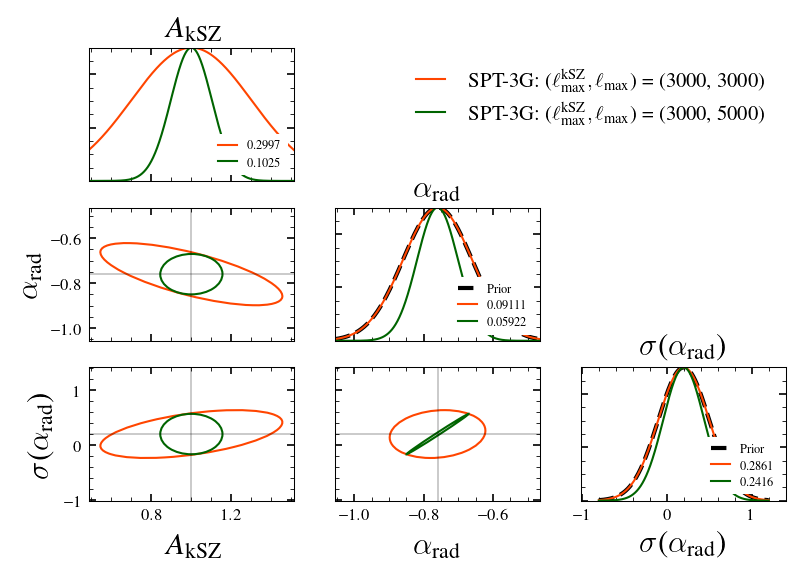

In [54]:
import tools_for_plotting
desired_params_to_plot = ['Aksz', 'alpha_radio', 'alpha_radio_sigma']
tmpnamearr = list(parent_F_dic[expname].keys())
colorarr = ['orangered', 'darkgreen']
color_dic = {}
for t, c in zip(tmpnamearr, colorarr):
    color_dic[t] = [c]

for tmpnamecntr, tmpname in enumerate( tmpnamearr ):
    if tmpnamecntr == 0:
        prior_dic_to_pass = prior_dic
    else:
        prior_dic_to_pass = {}
        
    tr, tc = tools_for_plotting.make_triangle_plot([tmpname], parent_F_dic[expname], param_dict, param_names, desired_params_to_plot, color_dic, ls_dic = None, one_or_two_sigma = 1, fsval = 11, prior_dic = prior_dic_to_pass)
ax = subplot(tr, tc, 3)
for tmpnamecntr, tmpname in enumerate( tmpnamearr ):
    plot([], [], color = color_dic[tmpname][0], label = r'%s: ($\ell_{\rm max}^{\rm kSZ}, \ell_{\rm max}$) = (%s, %s)' %(exp_specs_dict[expname][0], tmpname[0], tmpname[1]))
legend(loc = 1, fontsize = 10, framealpha = 0.)
axis('off')

	get fisher
MV
2000 6.071909036803356
3000 34.78097901982975
3500 52.353487814177605
4000 67.33569202370403
4500 84.62577025270568
5000 106.24571440568799
cross-ILC
2000 5.823830880165398
3000 31.088912853493213
3500 45.56383650397107
4000 56.773136656497314
4500 66.50673093488548
5000 75.03595771291796


In [286]:
#get Fisher / COV matrices with all 6 LCDM parameters fixed.
print('\tget fisher')
max_l_temp_arr = [2000, 3000, 3500, 4000, 4500, 5000]
delta_cl_dic_arr = [delta_cl_dic_mv, delta_cl_dic]
delta_cl_dic_str_arr = ['MV', 'cross-ILC']
for curr_delta_cl_dic, curr_delta_cl_dic_str in zip(delta_cl_dic_arr, delta_cl_dic_str_arr):
    print(curr_delta_cl_dic_str)
    
    for max_l_temp in max_l_temp_arr:
        F_mat = tools.get_fisher_matrix(els, cl_deriv_dic, curr_delta_cl_dic, param_names, pspectra_to_use = pspectra_to_use,\
                    min_l_temp = min_l_temp, max_l_temp = max_l_temp, min_l_pol = min_l_pol, max_l_pol = max_l_pol)

        fix_params = param_names[:-1]
        F_mat_mod = np.copy(F_mat)
        F_mat_mod, param_names_mod = tools.fix_params(F_mat_mod, param_names, fix_params)

        cov_mat = np.linalg.inv(F_mat_mod)
        sigma_Aksz = np.sqrt( cov_mat )
        snr_Aksz = Aksz/sigma_Aksz
        print(max_l_temp, snr_Aksz )
    

	get fisher
MV
2000 [[7.00101462]]
3000 [[49.87142162]]
3500 [[101.87620878]]
4000 [[165.06043112]]
4500 [[223.63333003]]
5000 [[272.26309535]]
cross-ILC
2000 [[6.91039183]]
3000 [[43.34957391]]
3500 [[74.1123125]]
4000 [[99.95877861]]
4500 [[118.21883196]]
5000 [[130.55687139]]
